# Using Kwant to simulate an optical waveguide

In [1]:
import kwant

import matplotlib.pyplot as plt
import numpy as np

# 1. Parameters

In [2]:
# length of the waveguides in units of 1/k
kL = 200 

# width of the waveguides in units of 1/k
kW = int(np.floor(40*2*np.pi)) 

# wavelength in um
lbda = 0.6 
k0 = 2*np.pi/lbda

# pitch of the mesh grid, i.e. spatial resolution of the system in units of 1/k 
a = 1.

# optical index of the leads 
n_leads = 1

# average index in the waveguide
n0 = 1

# strength of the disorder
eps_scat = 0.5

# map of the refractive index inside the waveguide
n = n0*(1+eps_scat*(0.5-np.random.rand(kL, kW)))


# 2. Create the system

We need to adapt the [example](https://kwant-project.org/doc/1/tutorial/first_steps) 
provided on the Kwant project website for photons. 
In Kwant, we need to give the element of the discretized Hamiltonian. 
It then solves the eigenvalue problem:

$$H \left|\psi\right\rangle = E \left|\psi\right\rangle \,,$$

with the Hamiltonian for a system with a perturbation potential $V(\vec{r})$:

$$H = \frac{\hbar}{2 m} \Delta + V(\vec{r})\,.$$


For an 2d optical waveguide, we consider the scalar Helmholtz equation:


$$\left[\Delta + n^2(\vec{r})k_0^2\right] \left|\psi\right\rangle = 0 \,,$$

with $k_0^2 = 2\pi/\lambda$ and $n^2(\vec{r})$ the refractive index in the waveguide.

We can then rewrite the system with:

$$H = \Delta + V(\vec{r})\,,$$

with 

$$V(\vec{r}) = k_0^2\left[n^2(\vec{r})-1\right]\,,$$

and 

$$E = k_0^2\,.$$

If we write all the length in units of $1/k$, we have:

$$V'(\vec{r}) = \left[n^2(\vec{r})-1\right]\,,$$

and 

$$E = 1\,.$$

In [3]:
# `disorder` potential inside the waveguide
V = n**2-1.

# potential inside the leads
V0 = n_leads**2-1

# parameter for the discretized derivative of the field (see Kwant tutorial)
t = 1/a**2

In [4]:
def make_system(a = a, t = t, W=kW, L=kL):
    # Start with an empty tight-binding system and a single square lattice.
    # `a` is the lattice constant (by default set to 1 for simplicity.
    lat = kwant.lattice.square(a)

    syst = kwant.Builder()
    for x in range(L):
        for y in range(W):
            syst[(lat(x, y)  )] = 4 * t +V[x,y]
#     syst[(lat(x, y) for x in range(L) for y in range(W))] = 4 * t
    syst[lat.neighbors()] = -t
    
    lead = kwant.Builder(kwant.TranslationalSymmetry((-a, 0)))
    lead[(lat(0, j) for j in range(W))] = 4 * t
    lead[lat.neighbors()] = -t
    
    syst.attach_lead(lead)
    syst.attach_lead(lead.reversed())

    return syst

In [5]:
syst = make_system()

## Visualize and finalized the system

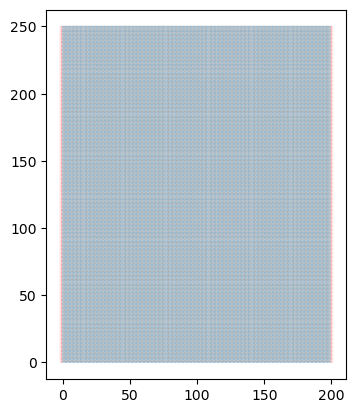

In [6]:
# Check that the system looks as intended.
kwant.plot(syst)

# Finalize the system.
syst = syst.finalized()

# Retrieve the transmission matrix

## First get the full $\mathbf{S}$ matrix

$\mathbf{S}$ contains the two reflections matrices 
and the two transmission matrices (left to right, right to left)
of the system.

In [7]:
smatrix = kwant.smatrix(syst, energy = 1)
S = smatrix.data

## Extract the left to right transmission matrix

In [8]:
n_modes = smatrix.data.shape[0]//2
T = S[n_modes:,:n_modes]

## Display the transmission matrix in the mode basis

<IPython.core.display.Javascript object>


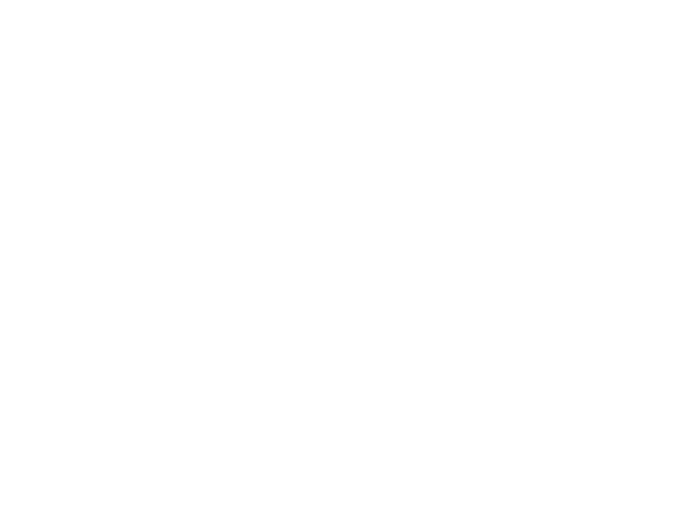

In [9]:
%matplotlib notebook
plt.figure()
plt.imshow(np.abs(T))

## Get the transmission matrix in the *pixel* basis

### Get the mode to pixel change-of-basis matrix

In [10]:
modes = syst.leads[0].modes(energy=1)[0].wave_functions[:,:n_modes]#.transpose()

**Show the change-of-basis matrix**

<IPython.core.display.Javascript object>


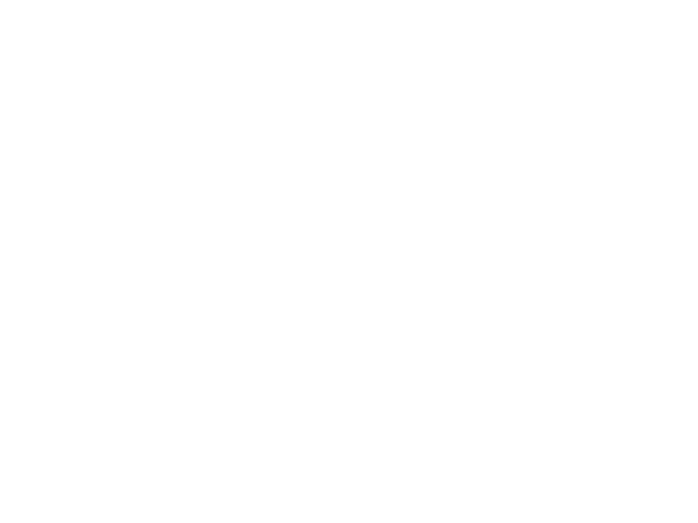

In [11]:
plt.figure()
plt.imshow(np.real(modes))

**Display the shape of one mode**

<IPython.core.display.Javascript object>


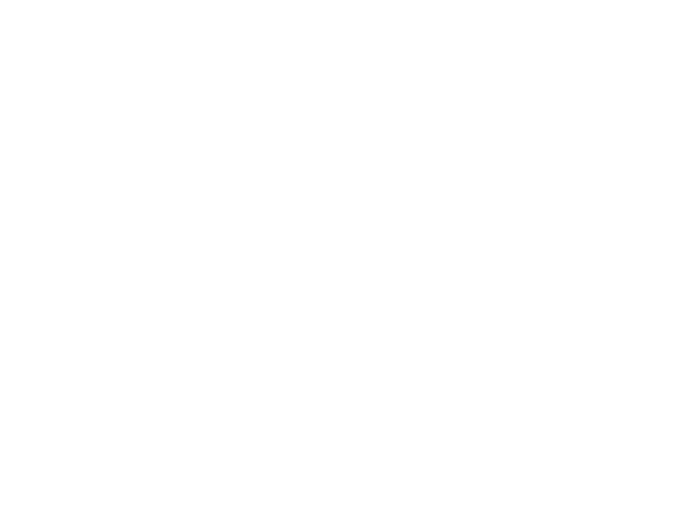

In [12]:
plt.figure()
plt.plot(np.real(modes[:,-4]))

### Project the transmission matrix in the pixel basis

In [13]:
T_pix = modes@T@modes.transpose().conjugate()

### Display the pixel basis transmission matrix

<IPython.core.display.Javascript object>


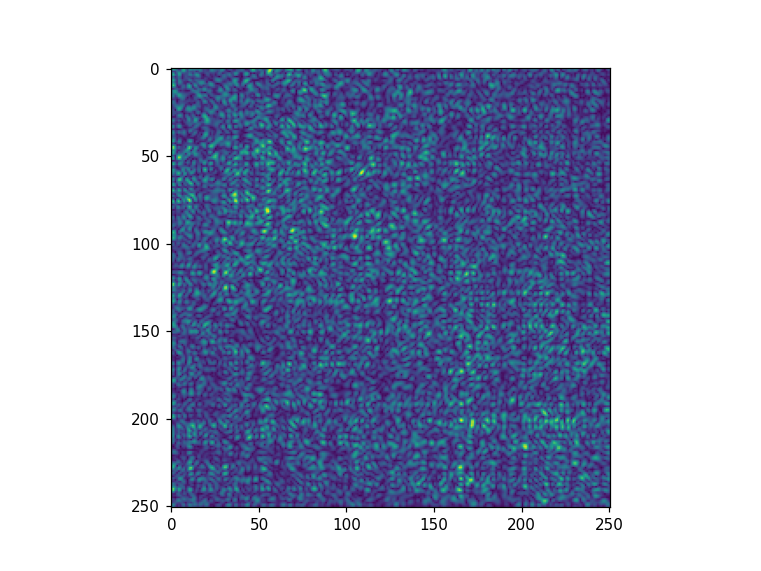

In [14]:
%matplotlib notebook
plt.figure()
plt.imshow(np.abs(T_pix))

# Compute SVD and select an open channel

## SVD

If the number of modes is high enough and if the system is in the strongly scattering regime 
(width of the system larger than the mean free path),
we should observe a bimodal distribution.

It requires to have a long enought system (`kL`)
and a strengh of the scattering (`e_scat`) high enough.

<IPython.core.display.Javascript object>


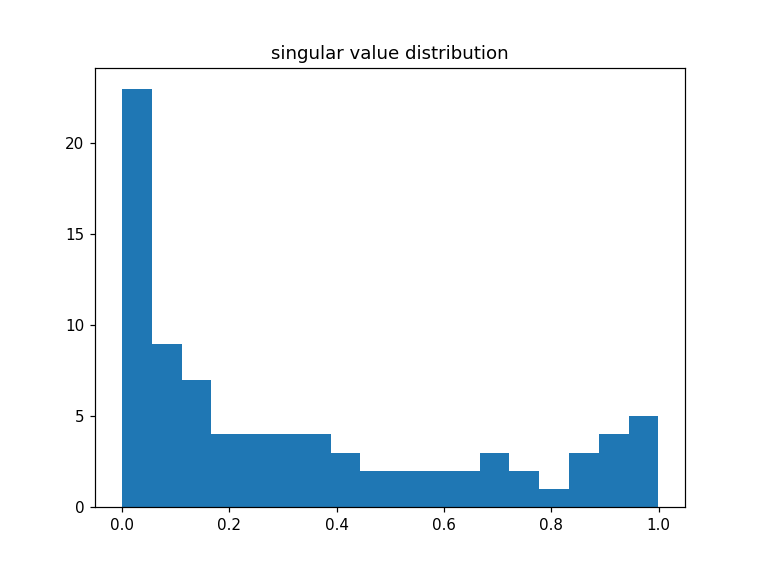

Text(0.5, 1.0, 'singular value distribution')

In [22]:
_,s,vh = np.linalg.svd(T)

plt.figure()
plt.hist(s, bins = 18)
plt.title('singular value distribution')

## Select an open channel

In [16]:
open_channel_mode = vh[0,:].conjugate()
open_channel_space = open_channel_mode@modes.transpose()

# Show the internal intensity map for an open channel

## Get the field for a given input wavefront from the left

In [17]:
from kwant.plotter import sys_leads_sites, sys_leads_pos, mask_interpolate


wf = kwant.wave_function(syst, energy= 1)
psi = wf(0)

def get_field(syst, psi, input_vec, method = 'cubic', oversampling = 1.):
    sites = sys_leads_sites(syst, 0)[0]
    coords = sys_leads_pos(syst, sites)
    field = psi.transpose()@open_channel_mode
    array = mask_interpolate(
        coords, field, a = None, 
        method = method,
        oversampling = oversampling
    )
    array = np.array(array, dtype = 'object')
    return array


## Get the intensity for the most open channel

In [18]:
phi = get_field(syst, psi, open_channel_mode)   
I = np.abs(phi[0]).transpose()**2

## Shwo the 2d intensity map

<IPython.core.display.Javascript object>


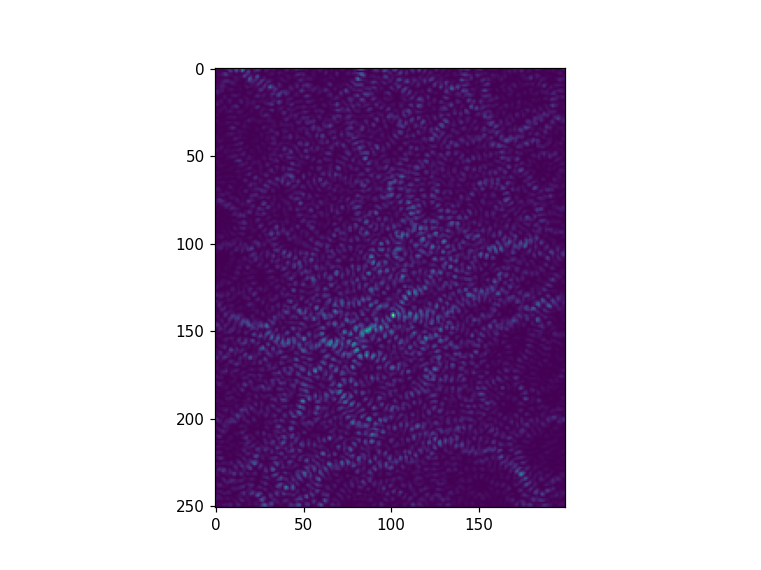

In [19]:
plt.figure()
plt.imshow(I)

## Show the projection on the propagation axis

<IPython.core.display.Javascript object>


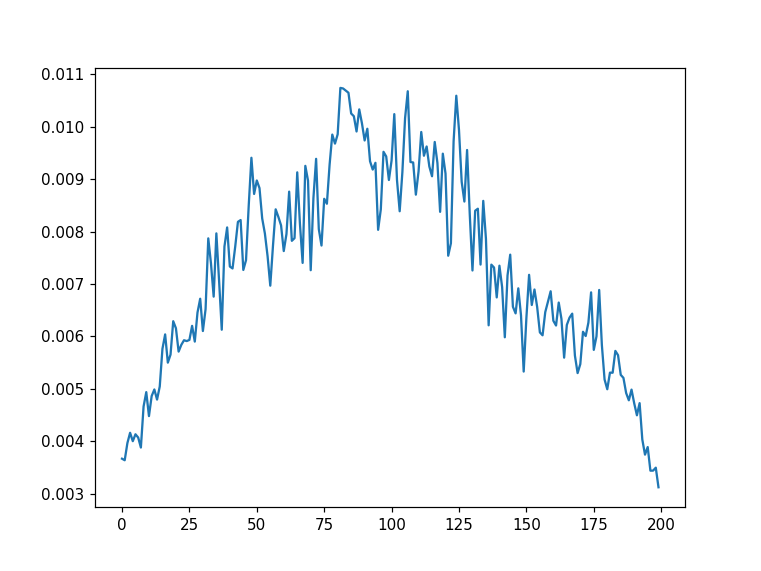

In [21]:
plt.figure()
plt.plot(np.mean(I, axis = 0))